In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import copy
import time
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

c:\Users\arthu\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Questão 1

### Dataset


In [632]:
# Definindo a função que adiciona ruído
def adicionar_ruido(entradas, raio_ruido):
    ruido = np.random.uniform(-raio_ruido, raio_ruido, entradas.shape)
    return entradas + ruido

# Definindo a função que gera dados ruidosos
def gerar_dados_com_ruido(entradas, respostas, raio_ruido, n_dados_por_ponto):
    entradas_ruidosas = np.vstack([adicionar_ruido(entradas, raio_ruido) for _ in range(n_dados_por_ponto)])
    respostas_ruidosas = np.tile(respostas, (n_dados_por_ponto, 1))
    return entradas_ruidosas, respostas_ruidosas

# Definindo os padrões de entrada (vértices do cubo)
entradas = np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1],
                     [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]])

# Vetores de resposta associados a cada padrão de entrada
respostas = np.eye(8) * 2 - 1  # Isso cria uma matriz identidade e converte para 1 e -1

# Gerando os dados ruidosos
raio_ruido = 0.1
n_dados_por_ponto = 125  # Como queremos 1000 pontos no total e temos 8 originais, precisamos de 125 de cada
entradas_ruidosas, respostas_ruidosas = gerar_dados_com_ruido(entradas, respostas, raio_ruido, n_dados_por_ponto)

entradas_ruidosas.shape, respostas_ruidosas.shape

((1000, 3), (1000, 8))

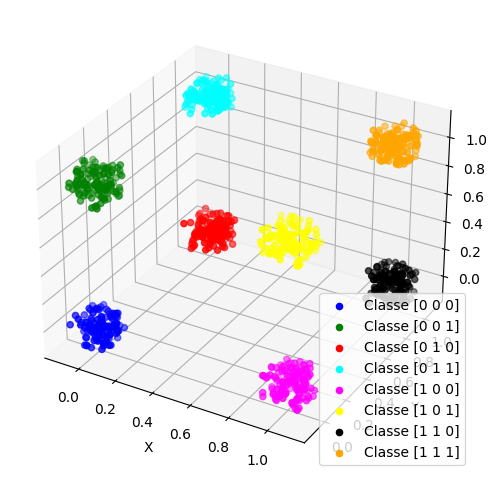

In [631]:
# Definindo cores diferentes para cada classe
cores = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange']

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotando os dados para cada classe
for i in range(entradas.shape[0]):
    indices_classe = respostas_ruidosas[:, i] == 1
    entradas_classe = entradas_ruidosas[indices_classe]
    ax.scatter(entradas_classe[:, 0], entradas_classe[:, 1], entradas_classe[:, 2], c=cores[i], label=f'Classe {entradas[i]}')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

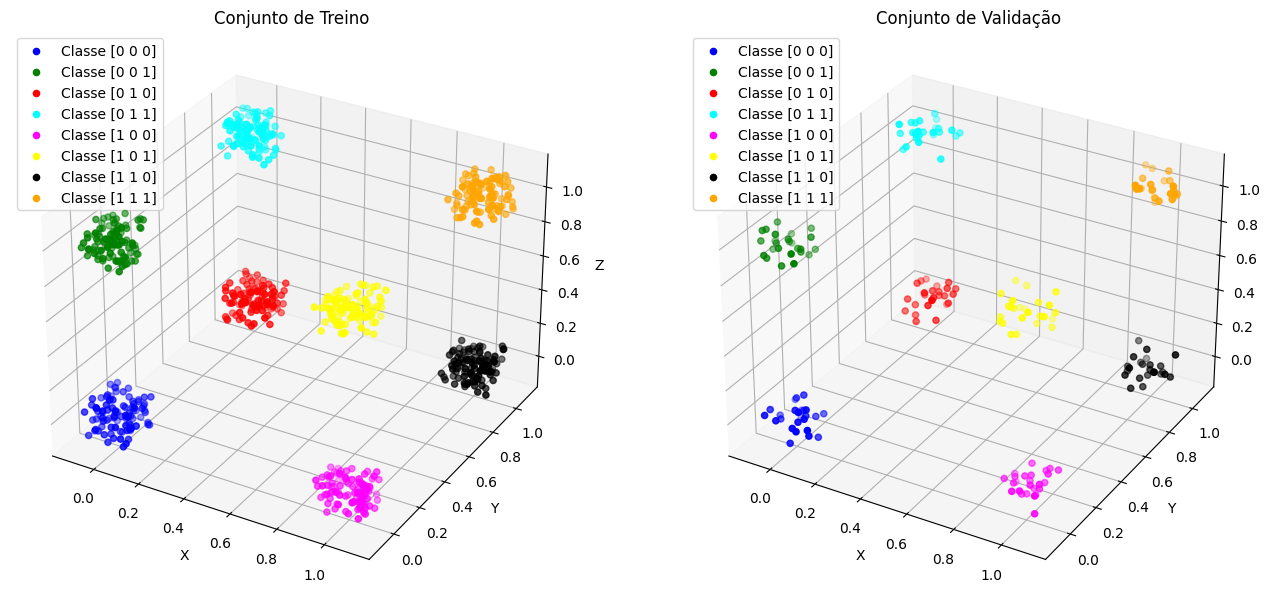

In [648]:
# Separando os dados em treino e validação
entradas_treino, entradas_validacao, respostas_treino, respostas_validacao = train_test_split(
    entradas_ruidosas, respostas_ruidosas, test_size=0.2, stratify=respostas_ruidosas.argmax(axis=1)
)

# Plotando os conjuntos de treino e validação
fig = plt.figure(figsize=(16, 8))

# Plot treino
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title('Conjunto de Treino')
for i in range(entradas.shape[0]):
    indices_classe = respostas_treino[:, i] == 1
    entradas_classe = entradas_treino[indices_classe]
    ax1.scatter(entradas_classe[:, 0], entradas_classe[:, 1], entradas_classe[:, 2], c=cores[i], label=f'Classe {entradas[i]}')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()

# Plot validação
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('Conjunto de Validação')
for i in range(entradas.shape[0]):
    indices_classe = respostas_validacao[:, i] == 1
    entradas_classe = entradas_validacao[indices_classe]
    ax2.scatter(entradas_classe[:, 0], entradas_classe[:, 1], entradas_classe[:, 2], c=cores[i], label=f'Classe {entradas[i]}')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.legend()

plt.show()

# Perceptron de Rosenblatt

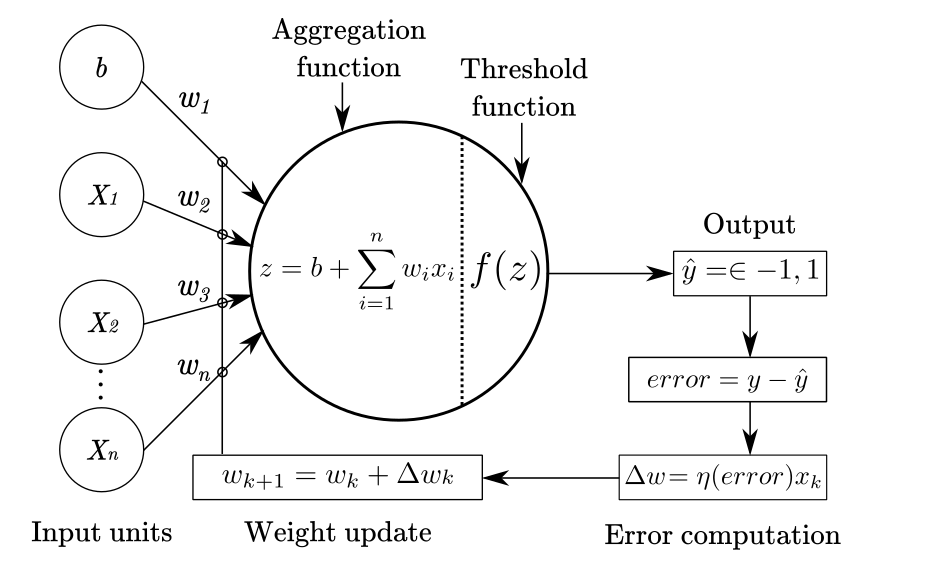

In [642]:
def initialize_parameters_delta(n_x, n_y):
    np.random.seed(1)  # Seed para garantir a reprodutibilidade
    W = np.random.randn(n_y, n_x) * 0.01 # Inicializa W com valores aleatórios pequenos
    b = np.zeros((n_y, 1)) # Inicializa b com zeros
    return {"W": W, "b": b}

def forward_propagation_delta(X, parameters):
    W = parameters['W']
    b = parameters['b']
    Z = np.dot(W, X) + b  # Combinador Linear + Bias(limiar de ativação)
    return Z  # Retorna o valor de Z diretamente

def update_parameters_one_vs_all_delta(parameters, X, Y, learning_rate):
    m = X.shape[1]  # Número de exemplos de treinamento
    W = parameters['W']
    b = parameters['b']
    
    for j in range(Y.shape[0]):  # Iterar sobre cada classe
        for i in range(m):  # Iterar sobre cada exemplo de treinamento
            xi = X[:, [i]] # Vetor de entrada
            yi = np.where(Y[j, i] == 1, 1, -1)  # yi é 1 se a classe atual for a classe correta, caso contrário -1
            Z = forward_propagation_delta(xi, {"W": W[[j], :], "b": b[[j], :]})
            A = np.where(Z > 0, 1, -1)  # Aplica a função de ativação (Função degrau)
            error = yi - A
            
            # Verifica se a previsão está errada antes de atualizar
            if np.sign(Z) != yi:  # Usa Z para verificar o erro
                W[j, :] = W[j, :] + learning_rate * error * xi.T # W de j é atualizado
                b[j, :] = b[j, :] + learning_rate * error # b de j é atualizado
            
    return {"W": W, "b": b}

def nn_model_delta(X, Y, num_iterations, learning_rate):
    n_x, n_y = X.shape[0], Y.shape[0]
    parameters = initialize_parameters_delta(n_x, n_y)
    for i in tqdm(range(num_iterations), desc="Training Progress"):
        parameters = update_parameters_one_vs_all_delta(parameters, X, Y, learning_rate)
    return parameters

In [659]:
# Função para treinar o modelo e calcular a acurácia no conjunto de validação
def train_and_evaluate_delta(X_train, Y_train, X_val, Y_val, num_iterations, learning_rate):
    parameters = nn_model_delta(X_train, Y_train, num_iterations, learning_rate)
    
    # Previsões no conjunto de treino
    A_train = forward_propagation_delta(X_train, parameters)
    predictions_train = np.where(A_train > 0, 1, -1)  # Modificado para corresponder ao formato de saída do modelo
    predictions_train_indices = np.argmax(predictions_train, axis=0)
    Y_train_indices = np.argmax(Y_train, axis=0)
    accuracy_train = accuracy_score(Y_train_indices, predictions_train_indices)

    # Previsões no conjunto de validação
    A_val = forward_propagation_delta(X_val, parameters)
    predictions_val = np.where(A_val > 0, 1, -1)  # Modificado para corresponder ao formato de saída do modelo
    Y_val_class = Y_val

    # Converter previsões e rótulos verdadeiros em índices de classes
    predictions_val_indices = np.argmax(predictions_val, axis=0)
    Y_val_indices = np.argmax(Y_val_class, axis=0)

    # Calcular a acurácia no conjunto de validação
    accuracy_val = accuracy_score(Y_val_indices, predictions_val_indices)

    # Acurácia de cada classe
    class_accuracies = []
    for i in range(Y_val_class.shape[0]):
        class_accuracies.append(accuracy_score(Y_val_class[i], predictions_val[i]))
    
    # Printar acurácia de cada classe
    print("Acurácia de cada classe no conjunto de validação:")
    for i, acc in enumerate(class_accuracies):
        print(f"Classe {i}: {acc * 100:.2f}%")

    return accuracy_train, accuracy_val, parameters

# Treinar o modelo e avaliar no conjunto de validação
accuracy_train, accuracy_val, parameters = train_and_evaluate_delta(entradas_treino.T, respostas_treino.T, entradas_validacao.T, respostas_validacao.T, num_iterations=1, learning_rate=0.1)
print(f"Acurácia no conjunto de treino: {accuracy_train * 100:.2f}%")
print(f"Acurácia no conjunto de validação: {accuracy_val * 100:.2f}%")

Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training Progress: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

Acurácia de cada classe no conjunto de validação:
Classe 0: 100.00%
Classe 1: 100.00%
Classe 2: 100.00%
Classe 3: 100.00%
Classe 4: 100.00%
Classe 5: 100.00%
Classe 6: 100.00%
Classe 7: 100.00%
Acurácia no conjunto de treino: 100.00%
Acurácia no conjunto de validação: 100.00%


# Questão 2

### Perceptron MLP

In [2]:
# Inicializa os parâmetros da rede neural para um modelo profundo
def initialize_parameters_deep(layer_dims):
    """
    Argumentos:
    layer_dims -- lista contendo as dimensões de cada camada da rede
    
    Retorna:
    parameters -- dicionário contendo os parâmetros "W1", "b1", ..., "WL", "bL":
                  Wl -- matriz de pesos da forma (layer_dims[l], layer_dims[l-1])
                  bl -- vetor de viés da forma (layer_dims[l], 1)
    """
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)  # Número de camadas na rede

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters

# Implementa a propagação linear para uma única camada
def linear_forward(A, W, b):
    """
    Argumentos:
    A -- ativações da camada anterior (ou dados de entrada): (tamanho da camada anterior, número de exemplos)
    W -- matriz de pesos: (tamanho da camada atual, tamanho da camada anterior)
    b -- vetor de viés: (tamanho da camada atual, 1)

    Retorna:
    Z -- a entrada da função de ativação, também chamada de pré-ativação
    cache -- uma tupla contendo "A", "W" e "b"; armazenado para a etapa de backpropagation
    """
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    
    return Z, cache

# Implementa a função de ativação Sigmoid
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache

# Implementa a função de ativação ReLU
def relu(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

# Implementa a função de ativação Softmax
def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    A = expZ / (np.sum(expZ, axis=0, keepdims=True) + 1e-8)
    cache = Z
    return A, cache

# Implementa a função de ativação Linear
def linear_activation(Z):
    """
    A função de ativação Linear retorna a entrada sem modificações.
    
    Argumentos:
    Z -- Saída da camada linear
    
    Retorna:
    A -- Ativações, neste caso igual a Z
    cache -- Z copiado, armazenado para uso na backpropagation
    """
    A = Z
    cache = Z
    return A, cache

# Implementa a propagação para frente para a camada LINEAR->ACTIVATION
def linear_activation_forward(A_prev, W, b, activation):
    """
    Argumentos:
    A_prev -- ativações da camada anterior (ou dados de entrada): (tamanho da camada anterior, número de exemplos)
    W -- matriz de pesos: (tamanho da camada atual, tamanho da camada anterior)
    b -- vetor de viés: (tamanho da camada atual, 1)
    activation -- a função de ativação a ser usada na camada atual, armazenada como uma string: "sigmoid", "relu" ou "linear"
    
    Retorna:
    A -- a saída da função de ativação, também chamada de pós-ativação
    cache -- uma tupla contendo "linear_cache" e "activation_cache";
             armazenado para a etapa de backpropagation
    """
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    elif activation == "linear":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = linear_activation(Z)
    elif activation == "softmax_hidden" or activation == "softmax_output":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)

    cache = (linear_cache, activation_cache)
    return A, cache


# Implementa a propagação para frente para o modelo [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID
def L_model_forward(X, parameters, hidden_activation='relu', output_activation='sigmoid'):
    """
    Argumentos:
    X -- dados de entrada, matriz de forma (tamanho da camada de entrada, número de exemplos)
    parameters -- saída de initialize_parameters_deep()
    hidden_activation -- a função de ativação a ser usada nas camadas ocultas
    output_activation -- a função de ativação a ser usada na camada de saída

    Retorna:
    AL -- última saída de ativação pós
    caches -- lista de caches contendo:
              cada cache de linear_activation_forward() (há L-1 delas, indexadas de 0 a L-2)
    """
    caches = []
    A = X
    L = len(parameters) // 2  # Número de camadas na rede

    
    for l in range(1, L):
        A_prev = A 
        # Aplica a função de ativação para todas as camadas ocultas
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation=hidden_activation)
        caches.append(cache)
    
    # Aplica a função de ativação para a camada de saída
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation=output_activation)
    caches.append(cache)
          
    return AL, caches

# Calcula o custo
def compute_cost(AL, Y, problema='regressao'):
    """
    Argumentos:
    AL -- vetor de ativações da última camada, correspondente à previsão: (1, número de exemplos)
    Y -- vetor de rótulos verdadeiros (para regressão) ou rótulos de classe (para classificação): (1, número de exemplos)
    problema -- tipo de problema, "regressao" ou "classificacao"

    Retorna:
    cost -- custo calculado
    """
    m = Y.shape[1]
    if problema == 'regressao':
        cost = (1./m) * np.sum(np.square(AL - Y)) # Custo quadrático médio (usado para regressão)
    elif problema == 'classificacao_binaria':
        cost = -(1./m) * (np.dot(Y, np.log(AL).T) + np.dot(1-Y, np.log(1-AL).T)) # Entropia cruzada binária (para problemas de classificação binária)
    elif problema == 'classificacao_multiclasse':
        cost = -(1./m) * np.sum(Y * np.log(AL + 1e-8))
    cost = np.squeeze(cost)  # Garante que o custo seja um escalar (e não um array de dimensão 1)
    return cost


def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache 
    m = A_prev.shape[1] 

    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True) 
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

# Implementa a retropropagação para a função de ativação SIGMOID
def sigmoid_backward(dA, cache):
    """
    Argumentos:
    dA -- gradiente da ativação pós-sigmoid para os exemplos
    cache -- 'Z' onde armazenamos a saída linear (cache de ativação)

    Retorna:
    dZ -- Gradiente do custo em relação a Z
    """
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s) # derivada da função de ativação SIGMOID
    return dZ

# Implementa a retropropagação para a função de ativação RELU
def relu_backward(dA, cache):
    """
    Argumentos:
    dA -- gradiente da ativação pós-relu para os exemplos
    cache -- 'Z' onde armazenamos a saída linear (cache de ativação)

    Retorna:
    dZ -- Gradiente do custo em relação a Z
    """
    Z = cache
    dZ = np.array(dA, copy=True) 
    dZ[Z <= 0] = 0 # derivada da função de ativação RELU
    return dZ

def softmax_backward(dA, cache):
    """
    Argumentos:
    dA -- gradiente da ativação pós-softmax para os exemplos
    cache -- 'Z' onde armazenamos a saída linear (cache de ativação)

    Retorna:
    dZ -- Gradiente do custo em relação a Z
    """
    dZ = dA * (1 - dA) # derivada da função de ativação SOFTMAX
    return dZ

# Implementa a retropropagação para a camada LINEAR->ACTIVATION
def linear_activation_backward(dA, cache, activation):
    """
    Argumentos:
    dA -- gradiente pós-ativação para a camada atual l
    cache -- tupla de valores (linear_cache, activation_cache) armazenados para calcular a retropropagação de forma eficiente
    activation -- a ativação a ser usada na camada ("sigmoid" ou "relu")

    Retorna:
    dA_prev -- Gradiente do custo em relação à ativação da camada anterior (l-1), mesma forma que A_prev
    dW -- Gradiente do custo em relação a W (camada atual l), mesma forma que W
    db -- Gradiente do custo em relação a b (camada atual l), mesma forma que b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    elif activation == "linear":
        dZ = dA
    elif activation == "softmax_hidden":
        dZ = softmax_backward(dA, activation_cache)
    elif activation == "softmax_output":
        dZ = dA
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

# Implementa a retropropagação para o modelo
def L_model_backward(AL, Y, caches, hidden_activation='relu', output_activation='sigmoid', problema='regressao'):
    """
    Argumentos:
    AL -- vetor de ativações da última camada, correspondente à previsão: (1, número de exemplos)
    Y -- vetor de rótulos verdadeiros (para regressão) ou rótulos de classe (para classificação): (1, número de exemplos)
    caches -- lista de caches contendo:
                cada cache de linear_activation_forward() (há L-1 delas, indexadas de 0 a L-2)
    hidden_activation -- a função de ativação a ser usada nas camadas ocultas
    output_activation -- a função de ativação a ser usada na camada de saída
    problema -- tipo de problema, "regressao" ou "classificacao"
    """
    
    grads = {} # Inicializa o dicionário de gradientes
    L = len(caches)  # número de camadas
    m = AL.shape[1] # número de exemplos
    Y = Y.reshape(AL.shape) # após esta linha, Y tem o mesmo formato que AL
    

    if problema == 'classificacao_binaria':   
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))  # Derivada da função de custo entropia cruzada binária
    elif problema == 'regressao':
        dAL = 2 * (AL - Y) / m # derivada do erro quadrático médio
    elif problema == 'classificacao_multiclasse':
        dAL = AL - Y # derivada da função de custo entropia cruzada categórica

    # Camada L (saída) gradientes.
    current_cache = caches[L-1] # cache da última camada

    # retropropagação da última camada
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, activation=output_activation)
    
    # armazena os gradientes 
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    # Loop de l= L-2 até l=0
    for l in reversed(range(L-1)):
        # Camadas ocultas
        current_cache = caches[l]

        # retropropagação da camada l
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, activation=hidden_activation)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

# Atualiza os parâmetros usando o gradiente descendente
def update_parameters(params, grads, learning_rate=0.001):
    """
    Argumentos:
    params -- dicionário contendo os parâmetros 
    grads -- dicionário contendo os gradientes, saída do L_model_backward
    learning_rate -- taxa de aprendizado

    Retorna:
    parameters -- dicionário contendo os parâmetros atualizados
    """
    parameters = copy.deepcopy(params)
    L = len(parameters) // 2  # Número de camadas na rede neural

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters


a) a função lógica XOR


In [67]:
# Definindo todas as possíveis entradas para a função XOR
x_samples = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])

# As saídas correspondentes para a função XOR
y_samples = np.array([0, 1, 1, 0])

# Usaremos todas as entradas para treinamento em um problema tão simples
x_train_a = x_samples
y_train_a = y_samples

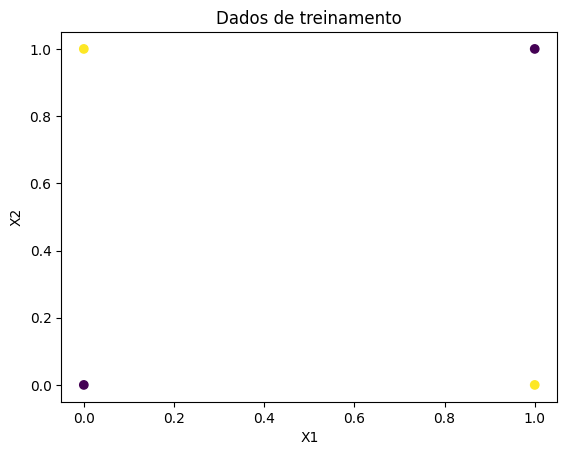

In [68]:
# Plotando os dados
plt.scatter(x_train_a[:, 0], x_train_a[:, 1], c=y_train_a, cmap='viridis')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Dados de treinamento')
plt.show()

Para a função XOR, é preferível usar funções de ativação não-lineares como a função sigmoid ou ReLU em todas as camadas ocultas. A função de ativação na camada de saída depende do tipo de problema que você está tentando resolver. No caso da função XOR, como é um problema de classificação binária, você geralmente usaria a função sigmoid na camada de saída para obter uma probabilidade como saída, que você pode então arredondar para obter uma previsão de classe binária (0 ou 1).

In [12]:
# Definindo a arquitetura da rede
layers_dims_a = [x_train_a.T.shape[0], 10, 1]  

# Inicializando os parâmetros
parameters_a = initialize_parameters_deep(layers_dims_a)

# Listas para armazenar custos
costs_train_a = []

# Treinamento da rede Por Lote (Batch)
for i in range(3001):
     # Propagação para frente (treinamento)
    AL_a, caches_a = L_model_forward(x_train_a.T, parameters_a, hidden_activation='relu', output_activation='sigmoid')
    
    # Cálculo do custo (treinamento)
    cost_train_a = compute_cost(AL_a, y_train_a.reshape(1, -1), problema='classificacao_binaria')
    costs_train_a.append(cost_train_a)
    
    # Propagação para trás
    grads_a = L_model_backward(AL_a, y_train_a.reshape(1, -1), caches_a, hidden_activation='relu', 
                               output_activation='sigmoid', problema='classificacao_binaria')
    
    # Atualização dos parâmetros
    parameters_a = update_parameters(parameters_a, grads_a, learning_rate = 0.1)
    
    
    # Imprimir o custo a cada 1000 iterações
    if i % 1000 == 0:
        print(f"Iteração {i} - Custo: {cost_train_a}")

# Acurácia no conjunto de treino
predictions_train_a = np.where(AL_a > 0.5, 1, 0)
accuracy_train_a = accuracy_score(y_train_a, predictions_train_a.reshape(-1))
print(f"Acurácia no conjunto de treino: {accuracy_train_a * 100:.2f}%")

Iteração 0 - Custo: 0.6931582391754034


Iteração 1000 - Custo: 0.3552798944892661
Iteração 2000 - Custo: 0.0236620019962228
Iteração 3000 - Custo: 0.009962258756132915
Acurácia no conjunto de treino: 100.00%


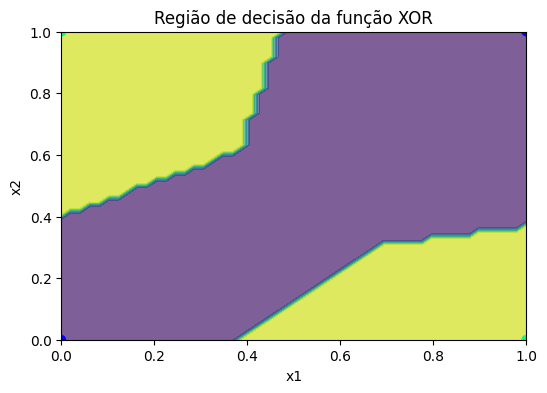

In [13]:
# Criar uma grade de pontos no intervalo de 0 a 1 (valores booleanos para XOR)
grid_x0, grid_x1 = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
grid = np.c_[grid_x0.ravel(), grid_x1.ravel()]

# Previsões para cada ponto na grade
AL_grid, _ = L_model_forward(grid.T, parameters_a, hidden_activation='relu', output_activation='sigmoid')
predictions_grid = (AL_grid > 0.5).astype(int)

# Visualizar a região de decisão
plt.figure(figsize=(6, 4))  # Aumentar o tamanho da figura
plt.contourf(grid_x0, grid_x1, predictions_grid.reshape(grid_x0.shape), alpha=0.7)
plt.scatter(x_train_a[:, 0], x_train_a[:, 1], c=y_train_a, cmap=plt.cm.winter)
plt.title("Região de decisão da função XOR")
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim(0, 1)  # Definir limites do eixo x
plt.ylim(0, 1)  # Definir limites do eixo y
plt.show()


b) f(x) = log10(x), onde 1 ≤ x ≤ 10


In [662]:
# Definindo a função b
def function_b(x):
    return np.log10(x)

# Gerar amostras para x (100 amostras uniformemente espaçadas entre 1 e 10)
x_samples_b = np.linspace(1, 10, 200) # 100 amostras uniformemente espaçadas entre 1 e 10
y_samples_b = function_b(x_samples_b) 

# Dividindo as amostras 
indices_b = np.random.permutation(len(x_samples_b))
train_indices_b = indices_b[:int(0.8*len(x_samples_b))]
val_indices_b = indices_b[int(0.8*len(x_samples_b)):]

# reshape pra prevenir rank 1 array, e fazer a transposição para que cada amostra seja uma coluna
x_train_b = x_samples_b[train_indices_b].reshape(1, -1)
y_train_b = y_samples_b[train_indices_b].reshape(1, -1)
x_val_b = x_samples_b[val_indices_b].reshape(1, -1)
y_val_b = y_samples_b[val_indices_b].reshape(1, -1)

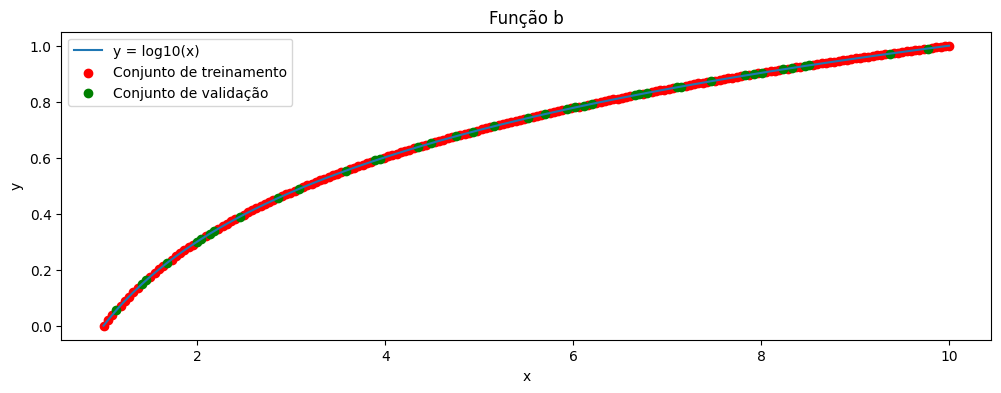

In [663]:
# plotar a função b
plt.figure(figsize=(12, 4))
plt.plot(x_samples_b, y_samples_b, label='y = log10(x)')
plt.scatter(x_train_b, y_train_b, color='r', label='Conjunto de treinamento')
plt.scatter(x_val_b, y_val_b, color='g', label='Conjunto de validação')
plt.title('Função b')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [664]:
# Calculando a média e o desvio padrão do conjunto de treinamento
mean_x_train_b = np.mean(x_train_b)
std_x_train_b = np.std(x_train_b)

mean_y_train_b = np.mean(y_train_b)
std_y_train_b = np.std(y_train_b)

# Padronização dos conjuntos de treinamento
x_train_b_standardized = (x_train_b - mean_x_train_b) / std_x_train_b
y_train_b_standardized = (y_train_b - mean_y_train_b) / std_y_train_b

# Padronização dos conjuntos de validação usando os mesmos parâmetros do conjunto de treinamento
x_val_b_standardized = (x_val_b - mean_x_train_b) / std_x_train_b
y_val_b_standardized = (y_val_b - mean_y_train_b) / std_y_train_b

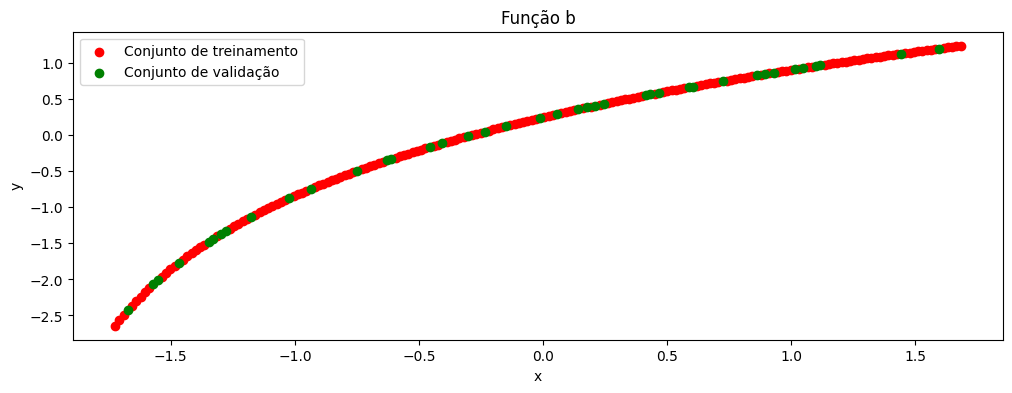

In [665]:
# plotar a função b
plt.figure(figsize=(12, 4))
plt.scatter(x_train_b_standardized, y_train_b_standardized, color='r', label='Conjunto de treinamento')
plt.scatter(x_val_b_standardized, y_val_b_standardized, color='g', label='Conjunto de validação')
plt.title('Função b')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

A camada de saída tem 1 neurônio, o que é típico para problemas de regressão, onde você está tentando prever um único valor contínuo.

In [666]:
# Definindo a arquitetura da rede
layer_dims_b = [x_train_b_standardized.shape[0], 100, 1] 

# Inicializando os parâmetros
parameters_b = initialize_parameters_deep(layer_dims_b)

# Lista para armazenar os custos de treinamento e validação
training_costs = []
validation_costs = []

# Treinamento do modelo Por Lote (Batch)
for i in range(50000):
    # Forward propagation
    AL_b, caches_b = L_model_forward(x_train_b_standardized, parameters_b, hidden_activation='relu', output_activation='linear')
    
    # Compute cost.
    cost_train = compute_cost(AL_b, y_train_b_standardized, problema='regressao')
    training_costs.append(cost_train)
    
    # Backward propagation.
    grads_b = L_model_backward(AL_b, y_train_b_standardized, caches_b, hidden_activation='relu', output_activation='linear', problema='regressao')
    
    # Update parameters.
    parameters_b = update_parameters(parameters_b, grads_b, learning_rate=0.1)
    
    # Compute validation cost.
    AL_val_b, _ = L_model_forward(x_val_b_standardized, parameters_b, hidden_activation='relu', output_activation='linear')
    cost_val = compute_cost(AL_val_b, y_val_b_standardized, problema='regressao')
    validation_costs.append(cost_val)
    
    if i % 10000 == 0:
        print(f"Iteração {i} - Custo de Treinamento: {cost_train} - Custo de Validação: {cost_val}")

    if cost_train <= 0.01:
        break


Iteração 0 - Custo de Treinamento: 1.002398871067714 - Custo de Validação: 1.0039865129750638
Iteração 10000 - Custo de Treinamento: 0.029081829347087657 - Custo de Validação: 0.02522010213624013
Iteração 20000 - Custo de Treinamento: 0.025729810872737492 - Custo de Validação: 0.023562856954722756
Iteração 30000 - Custo de Treinamento: 0.023759224582983386 - Custo de Validação: 0.022054817021668255
Iteração 40000 - Custo de Treinamento: 0.02168041172233029 - Custo de Validação: 0.01962169711158295


Erro Quadrático Médio: 0.0167


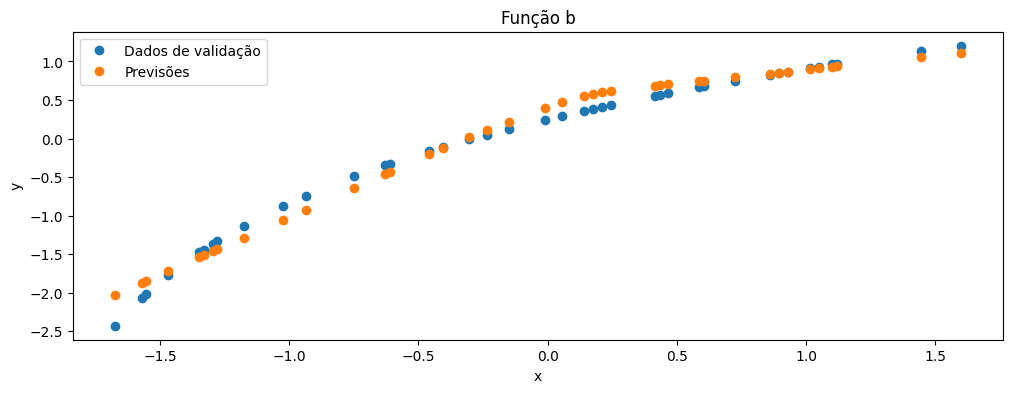

In [684]:
# Propagação para frente para fazer previsões com o modelo treinado
AL_test, _ = L_model_forward(x_val_b_standardized, parameters_b, hidden_activation='relu', output_activation='linear')

# Erro quadrático médio
mse = np.mean((AL_test - y_val_b_standardized)**2)
print(f"Erro Quadrático Médio: {mse:.4f}")

# Plotar a função b
plt.figure(figsize=(12, 4))
plt.plot(x_val_b_standardized.T, y_val_b_standardized.T, 'o', label='Dados de validação')
plt.plot(x_val_b_standardized.T, AL_test.T, 'o', label='Previsões')
plt.title('Função b')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

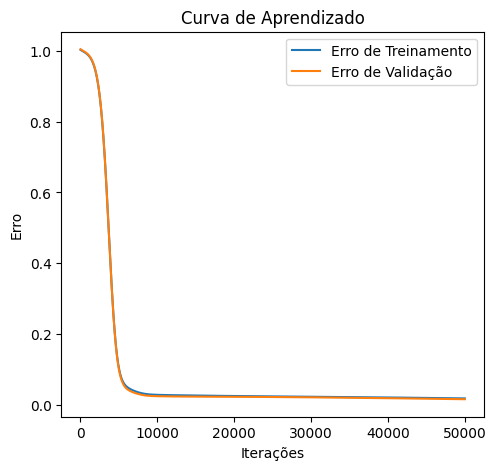

In [685]:
# Plotting the training and validation cost
plt.figure(figsize=(12, 5))

# Plot training cost
plt.subplot(1, 2, 1)
plt.plot(training_costs, label='Erro de Treinamento')
plt.plot(validation_costs, label='Erro de Validação')
plt.ylabel('Erro')
plt.xlabel('Iterações')
plt.title("Curva de Aprendizado")
plt.legend()
plt.show()

c) f(x) = 10x5+ 5x4+ 2x3– 0.5x2+ 3x + 2, onde 0 ≤ x ≤ 5


In [686]:
# Definindo a função complexa para aproximação
def function_c(x):
    return 10*x**5 + 5*x**4 + 2*x**3 - 0.5*x**2 + 3*x + 2

# Gerando dados de amostra 
x_samples_c = np.linspace(0, 5, 500)  # 500 amostras entre 0 e 5
y_samples_c = function_c(x_samples_c)

# Dividindo os dados em conjuntos de treinamento e validação
indices_c = np.random.permutation(len(x_samples_c))
train_indices_c = indices_c[:int(0.8*len(x_samples_c))]
val_indices_c = indices_c[int(0.8*len(x_samples_c)):]

x_train_c = x_samples_c[train_indices_c].reshape(1, -1)
y_train_c = y_samples_c[train_indices_c].reshape(1, -1)
x_val_c = x_samples_c[val_indices_c].reshape(1, -1)
y_val_c = y_samples_c[val_indices_c].reshape(1, -1)

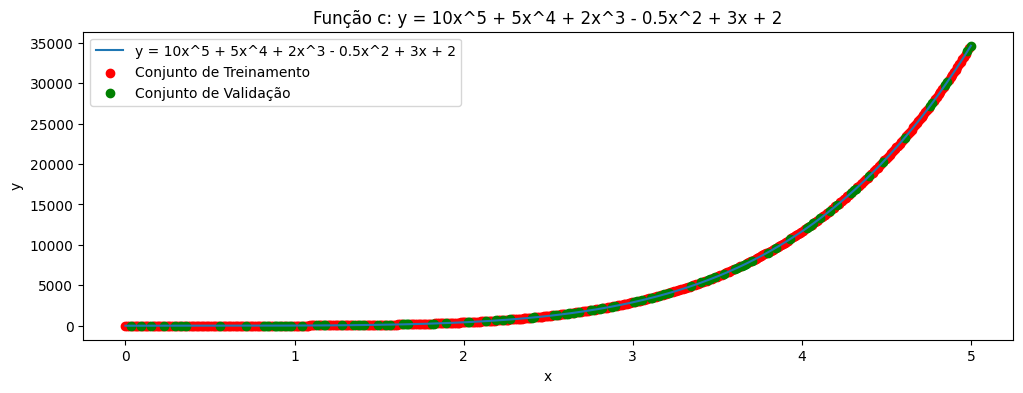

In [687]:
# Plotando a função c
plt.figure(figsize=(12, 4))
plt.plot(x_samples_c, y_samples_c, label='y = 10x^5 + 5x^4 + 2x^3 - 0.5x^2 + 3x + 2')
plt.scatter(x_train_c, y_train_c, color='r', label='Conjunto de Treinamento')
plt.scatter(x_val_c, y_val_c, color='g', label='Conjunto de Validação')
plt.title('Função c: y = 10x^5 + 5x^4 + 2x^3 - 0.5x^2 + 3x + 2')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [688]:
# Calculando a média e o desvio padrão do conjunto de treinamento
mean_x_train_c = np.mean(x_train_c)
std_x_train_c = np.std(x_train_c)

mean_y_train_c = np.mean(y_train_c)
std_y_train_c = np.std(y_train_c)

# Padronização dos conjuntos de treinamento
x_train_c_standardized = (x_train_c - mean_x_train_c) / std_x_train_c
y_train_c_standardized = (y_train_c - mean_y_train_c) / std_y_train_c

# Padronização dos conjuntos de validação usando os mesmos parâmetros do conjunto de treinamento
x_val_c_standardized = (x_val_c - mean_x_train_c) / std_x_train_c
y_val_c_standardized = (y_val_c - mean_y_train_c) / std_y_train_c

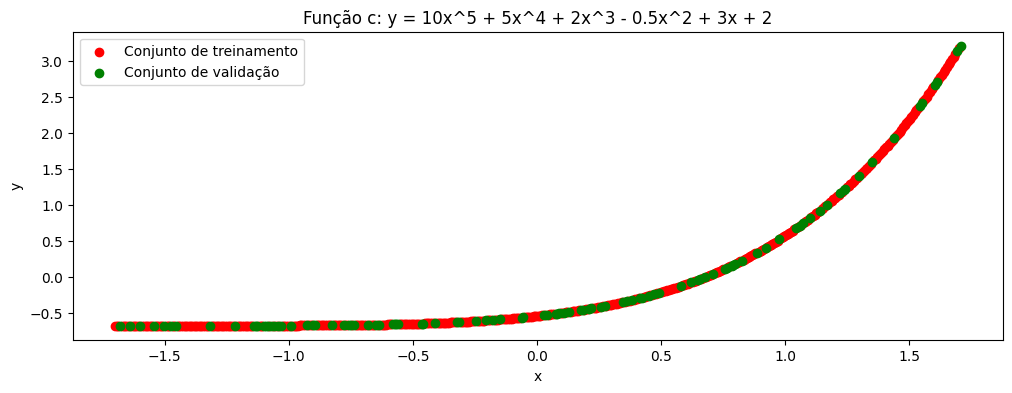

In [689]:
# plotar a função c
plt.figure(figsize=(12, 4))
plt.scatter(x_train_c_standardized, y_train_c_standardized, color='r', label='Conjunto de treinamento')
plt.scatter(x_val_c_standardized, y_val_c_standardized, color='g', label='Conjunto de validação')
plt.title('Função c: y = 10x^5 + 5x^4 + 2x^3 - 0.5x^2 + 3x + 2')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Precisou de mais exemplos de treinamento para um resultado bom

In [690]:
# Definindo a arquitetura da rede para a função c
layer_dims_c = [x_train_c_standardized.shape[0], 100, 1] 

# Inicializando os parâmetros para a função c
parameters_c = initialize_parameters_deep(layer_dims_c)

# Lista para armazenar os custos de treinamento e validação
training_costs_c = []
validation_costs_c = []

# Treinamento do modelo Por Lote (Batch)
for i in range(25000):
    # Forward propagation
    AL_c, caches_c = L_model_forward(x_train_c_standardized, parameters_c, hidden_activation='relu', output_activation='linear')
    
    # Compute cost.
    cost_train_c = compute_cost(AL_c, y_train_c_standardized, problema='regressao')
    training_costs_c.append(cost_train_c)
    
    # Backward propagation.
    grads_c = L_model_backward(AL_c, y_train_c_standardized, caches_c, hidden_activation='relu', output_activation='linear', problema='regressao')
    
    # Update parameters.
    parameters_c = update_parameters(parameters_c, grads_c, learning_rate=0.1)
    
    # Compute validation cost.
    AL_val_c, _ = L_model_forward(x_val_c_standardized, parameters_c, hidden_activation='relu', output_activation='linear')
    cost_val_c = compute_cost(AL_val_c, y_val_c_standardized, problema='regressao')
    validation_costs_c.append(cost_val_c)
    
    if i % 10000 == 0:
        print(f"Iteração {i} - Custo de Treinamento: {cost_train_c} - Custo de Validação: {cost_val_c}")

    if cost_train_c <= 0.01:
        break

Iteração 0 - Custo de Treinamento: 1.0016994296816117 - Custo de Validação: 0.8699888214913877
Iteração 10000 - Custo de Treinamento: 0.5654417201833343 - Custo de Validação: 0.5117725065551841
Iteração 20000 - Custo de Treinamento: 0.1069328049403545 - Custo de Validação: 0.11639487490233284


Erro Quadrático Médio: 0.0906


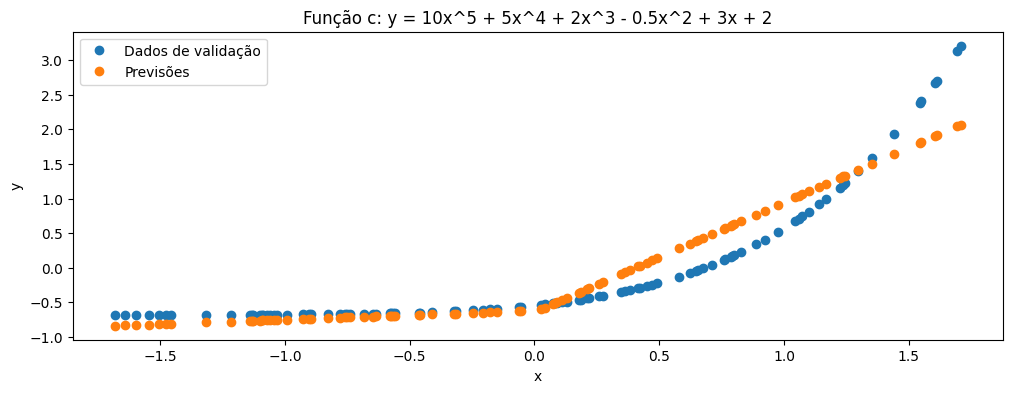

In [691]:
# Propagação para frente para fazer previsões com o modelo treinado
AL_test_c, _ = L_model_forward(x_val_c_standardized, parameters_c, hidden_activation='relu', output_activation='linear')

# Erro quadrático médio
mse_c = np.mean((AL_test_c - y_val_c_standardized)**2)  
print(f"Erro Quadrático Médio: {mse_c:.4f}")

# Plotar a função c
plt.figure(figsize=(12, 4))
plt.plot(x_val_c_standardized.T, y_val_c_standardized.T, 'o', label='Dados de validação')
plt.plot(x_val_c_standardized.T, AL_test_c.T, 'o', label='Previsões')
plt.title('Função c: y = 10x^5 + 5x^4 + 2x^3 - 0.5x^2 + 3x + 2')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

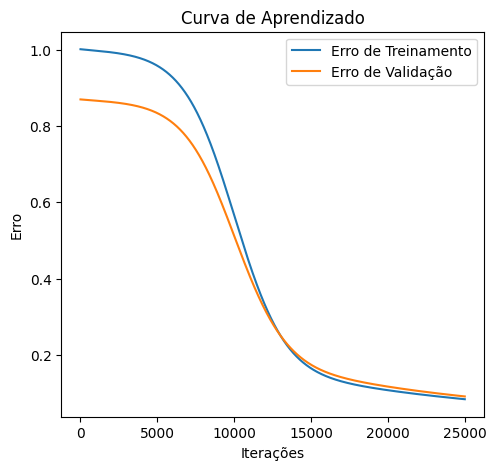

In [692]:
# Plotting the training and validation cost
plt.figure(figsize=(12, 5))

# Plot training cost
plt.subplot(1, 2, 1)
plt.plot(training_costs_c, label='Erro de Treinamento')
plt.plot(validation_costs_c, label='Erro de Validação')
plt.ylabel('Erro')
plt.xlabel('Iterações')
plt.title("Curva de Aprendizado")
plt.legend()
plt.show()


# Questão 3

In [3]:
# Define a função para gerar pontos aleatórios dentro de um círculo
def pontos_dentro_do_circulo(k):
    pontos = []
    for _ in range(k):
        angle = random.uniform(0, 2 * np.pi)
        r = np.sqrt(random.uniform(0, 1))  # Distribuição uniforme em área
        x = r * np.cos(angle)
        y = r * np.sin(angle)
        pontos.append((x, y))
    return pontos

# Função para calcular o y de um ponto na reta dada a entrada x
def calcular_y_do_ponto_da_reta(p1, p2, x_):
    m = (p2[1] - p1[1]) / (p2[0] - p1[0])
    b = p1[1] - m * p1[0]
    return m * x_ + b

# Gerar pontos aleatórios
n_ex = 5000  # Número de exemplos, 1500 foi o suficiente pra generalizar bem nos dados de validação
pontos = pontos_dentro_do_circulo(n_ex)

# Círculo
theta = np.linspace(0, 2 * np.pi, 100)
x_circle = np.cos(theta)
y_circle = np.sin(theta)

# Desenha o losango
x_diamond = [0, 1, 0, -1, 0]
y_diamond = [1, 0, -1, 0, 1]

In [4]:
# Transformar pontos em uma matriz Numpy
X = np.array([list(p) for p in pontos])  # Transposta para ter a forma correta (2, n_ex)

# Criar a matriz de rótulos Y. Inicialmente tudo zero.
Y = np.zeros((8, len(pontos)))  # 8 classes, n_ex exemplos

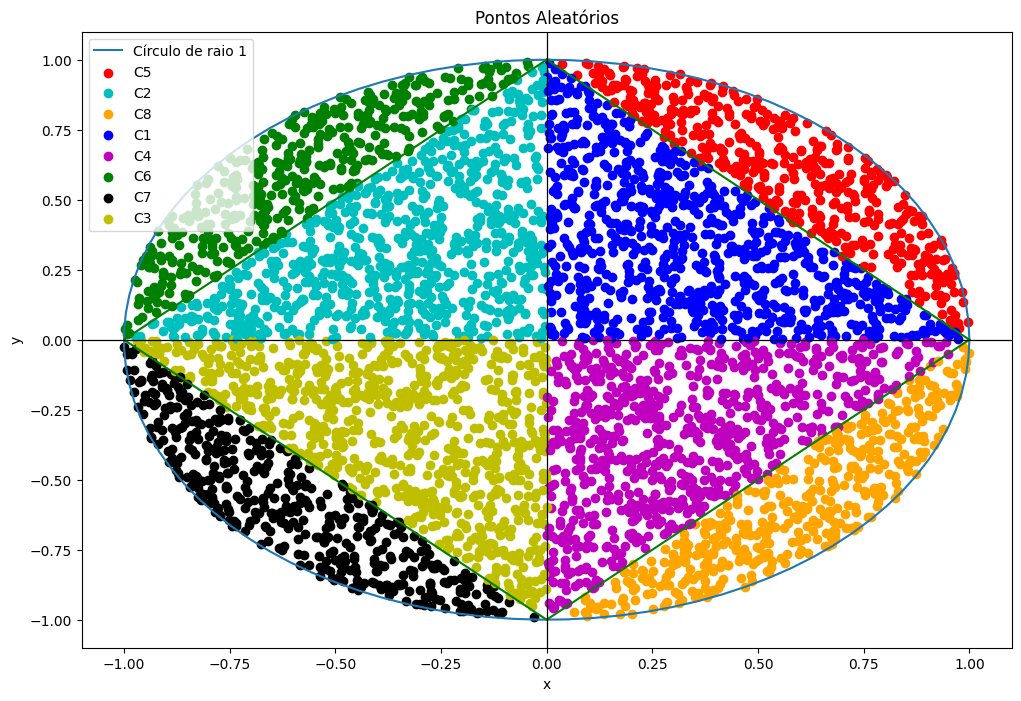

In [5]:
# Plotar o círculo, o losango e os pontos com labels para cada classe
plt.figure(figsize=(12, 8))
plt.plot(x_circle, y_circle, label='Círculo de raio 1')
plt.plot(x_diamond, y_diamond, color='g')  # Losango não precisa de label repetido
plt.axvline(x=0, color='k', linestyle='-', linewidth=0.9)
plt.axhline(y=0, color='k', linestyle='-', linewidth=0.9)

# Dicionário para mapear classes para cores e labels
class_dict = {
    0: ('b', 'C1'),
    1: ('c', 'C2'),
    2: ('y', 'C3'),
    3: ('m', 'C4'),
    4: ('r', 'C5'),
    5: ('g', 'C6'),
    6: ('k', 'C7'),
    7: ('orange', 'C8')
}

# Inicializa um dicionário para rastrear se a legenda já foi adicionada
legend_added = {key: False for key in class_dict}
lista = []
# Plotar os pontos classificados com labels
for x, y in pontos:
    # Calcula a classificação para determinar a cor e o label
    if x > 0 and y > 0 and y < calcular_y_do_ponto_da_reta((0,1),(1,0),x):
        class_idx = 0
        lista.append([1, 0, 0, 0, 0, 0, 0, 0])
    elif x < 0 and y > 0 and y < calcular_y_do_ponto_da_reta((0,1),(-1,0),x):
        class_idx = 1
        lista.append( [0, 1, 0, 0, 0, 0, 0, 0])
    elif x < 0 and y < 0 and y > calcular_y_do_ponto_da_reta((0,-1),(-1,0),x):
        class_idx = 2
        lista.append([0, 0, 1, 0, 0, 0, 0, 0])
    elif x > 0 and y < 0 and y > calcular_y_do_ponto_da_reta((0,-1),(1,0),x):
        class_idx = 3
        lista.append([0, 0, 0, 1, 0, 0, 0, 0])
    elif x > 0 and y > 0 and y > calcular_y_do_ponto_da_reta((0,1),(1,0),x):
        class_idx = 4
        lista.append( [0, 0, 0, 0, 1, 0, 0, 0])
    elif x < 0 and y > 0 and y > calcular_y_do_ponto_da_reta((0,1),(-1,0),x):
        class_idx = 5
        lista.append( [0, 0, 0, 0, 0, 1, 0, 0])
    elif x < 0 and y < 0 and y < calcular_y_do_ponto_da_reta((0,-1),(-1,0),x):
        class_idx = 6
        lista.append( [0, 0, 0, 0, 0, 0, 1, 0])
    elif x > 0 and y < 0 and y < calcular_y_do_ponto_da_reta((0,-1),(1,0),x):
        class_idx = 7
        lista.append( [0, 0, 0, 0, 0, 0, 0, 1])
    

    # Obtém a cor e o label da classe
    color, label = class_dict[class_idx]

    # Plota o ponto e adiciona a legenda se ainda não foi adicionada
    if not legend_added[class_idx]:
        plt.scatter(x, y, color=color, label=label)
        legend_added[class_idx] = True
    else:
        plt.scatter(x, y, color=color)

plt.title('Pontos Aleatórios')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [6]:
# Deixar apenas as classes no diciionário
class_dict = {
    0: 'C1',
    1: 'C2',
    2: 'C3',
    3: 'C4',
    4: 'C5',
    5: 'C6',
    6: 'C7',
    7: 'C8'
}

# Transformar a lista em um array numpy
Y = np.array(lista)

# Separar os dados em conjuntos de treinamento, validação e teste
indices = np.random.permutation(len(X))
train_indices = indices[:int(0.8*len(X))]
val_indices = indices[int(0.8*len(X)):]

X_train = X[train_indices].T
Y_train = Y[train_indices].T
X_val = X[val_indices].T
Y_val = Y[val_indices].T

In [7]:
X_train.shape

(2, 4000)

In [8]:
Y_train.shape

(8, 4000)

### Regra delta

Regra Delta é dada pela fórmula:

$$ \Delta w = \eta \cdot (y - \hat{y}) \cdot x $$

Onde:
- $ \Delta w $ é a mudança aplicada ao peso.
- $ \eta $ é a taxa de aprendizado, um parâmetro que determina o tamanho do passo da atualização do peso.
- $ y $ é o valor real (ou desejado) da saída.
- $ \hat{y} $ é a saída prevista pela rede neural.
- $ x $ é a entrada do neurônio.



In [18]:
def train_and_evaluate(X_train, Y_train, X_val, Y_val, num_iterations, learning_rate, n_hidden_neurons):
    # Definir a arquitetura da rede e inicializar os parâmetros
    layers_dims = [X_train.shape[0], n_hidden_neurons, Y_train.shape[0]]
    parameters = initialize_parameters_deep(layers_dims)
    

    for i in range(num_iterations):
        # Propagação para frente, cálculo do custo e propagação para trás para treinamento
        AL_train, caches_train = L_model_forward(X_train, parameters, hidden_activation='relu', output_activation='softmax_output')
        cost_train = compute_cost(AL_train, Y_train, problema='classificacao_multiclasse')
        grads = L_model_backward(AL_train, Y_train, caches_train, hidden_activation='relu', output_activation='softmax_output', problema='classificacao_multiclasse')
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Propagação para frente e cálculo do custo para validação
        AL_val, _ = L_model_forward(X_val, parameters, hidden_activation='relu', output_activation='softmax_output')
        cost_val = compute_cost(AL_val, Y_val, problema='classificacao_multiclasse')
        
        # Imprimir o custo periodicamente
        if i % 10000 == 0 or i == num_iterations - 1:
            print(f"Iteração {i} - Custo de Treinamento: {cost_train:.4f} - Custo de Validação: {cost_val:.4f}")

        # Parar o treinamento se o custo for menor que 0.04
        if cost_train <= 0.09 and cost_val <= 0.09:
            break

    # Calcular acurácias
    predictions_train = np.argmax(AL_train, axis=0)
    true_labels_train = np.argmax(Y_train, axis=0)
    predictions_val = np.argmax(AL_val, axis=0)
    true_labels_val = np.argmax(Y_val, axis=0)
    accuracy_train = accuracy_score(true_labels_train, predictions_train)
    accuracy_val = accuracy_score(true_labels_val, predictions_val)
    print(f"Acurácia no conjunto de treinamento: {accuracy_train * 100:.2f}%")
    print(f"Acurácia no conjunto de validação: {accuracy_val * 100:.2f}%")

    # Calcular e imprimir acurácia por classe
    cm = confusion_matrix(true_labels_val, predictions_val)
    accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
    for i, accuracy in enumerate(accuracy_per_class):
        print(f"Acurácia da Classe {i} no conjunto de validação: {accuracy * 100:.2f}%")

    return cm, parameters

star = time.time()
print("Para 10 neurônios na camada oculta:")
# Assumindo que X_train, Y_train, X_val, Y_val já estão definidos
conf_matrix, parameters = train_and_evaluate(X_train, Y_train, X_val, Y_val, num_iterations=100000, learning_rate=0.1, n_hidden_neurons = 100)
end = time.time()
print(f"Tempo de execução: {end - star:.2f} segundos")

Para 10 neurônios na camada oculta:
Iteração 0 - Custo de Treinamento: 2.0794 - Custo de Validação: 2.0784
Iteração 10000 - Custo de Treinamento: 0.0996 - Custo de Validação: 0.1025
Acurácia no conjunto de treinamento: 99.40%
Acurácia no conjunto de validação: 99.40%
Acurácia da Classe 0 no conjunto de validação: 99.44%
Acurácia da Classe 1 no conjunto de validação: 100.00%
Acurácia da Classe 2 no conjunto de validação: 100.00%
Acurácia da Classe 3 no conjunto de validação: 98.65%
Acurácia da Classe 4 no conjunto de validação: 100.00%
Acurácia da Classe 5 no conjunto de validação: 99.04%
Acurácia da Classe 6 no conjunto de validação: 98.04%
Acurácia da Classe 7 no conjunto de validação: 100.00%
Tempo de execução: 167.20 segundos


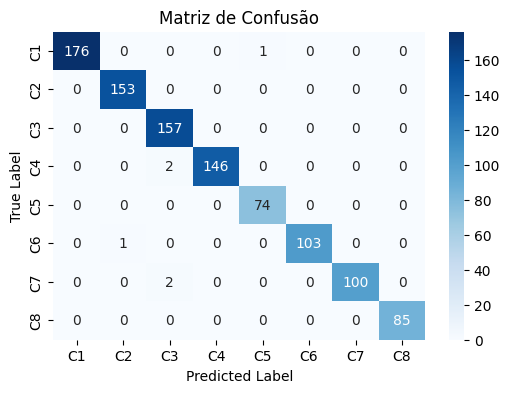

In [19]:
# Converter os índices para os rótulos conforme definido em class_dict
labels = [class_dict[i] for i in range(len(class_dict))]

# Plotar a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de Confusão')
plt.show()

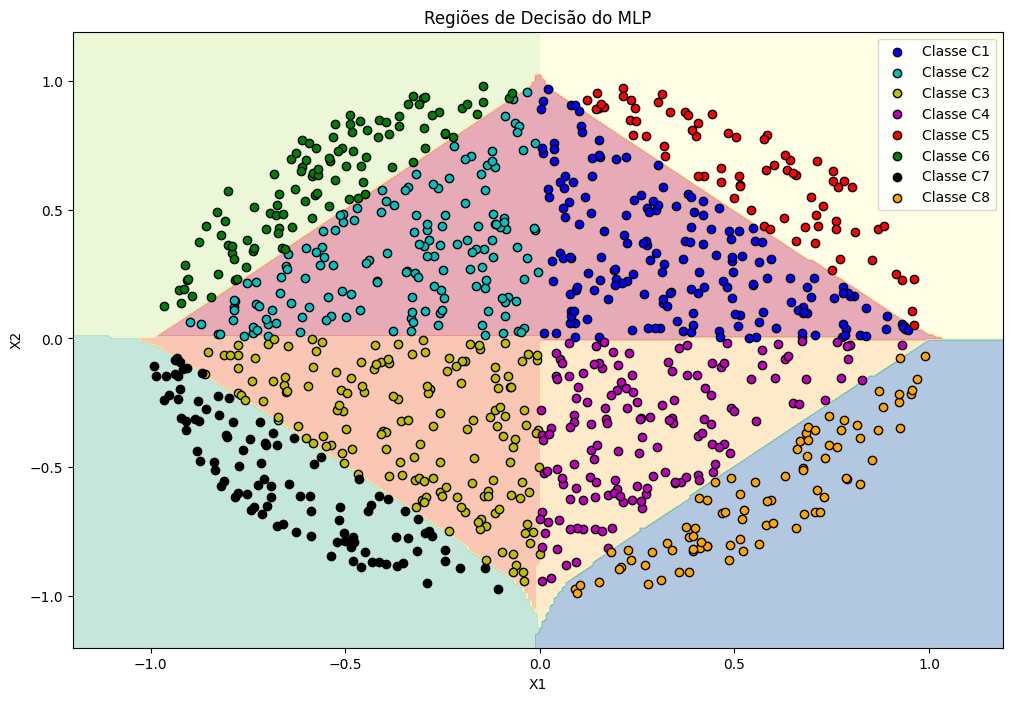

In [20]:
# Definir os limites da grade e criar uma grade de pontos
x_min, x_max = -1.2, 1.2
y_min, y_max = -1.2, 1.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Prever classes para cada ponto na grade
grid_points = np.c_[xx.ravel(), yy.ravel()] 
AL_grid, _ = L_model_forward(grid_points.T, parameters, hidden_activation='relu', output_activation='softmax_output')
predictions_grid = np.argmax(AL_grid, axis=0)

# Correção para plotar as regiões de decisão
Z = predictions_grid.reshape(xx.shape)
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.4, cmap='Spectral')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# Plotar os pontos de validação
for i, color in enumerate(['blue', 'c', 'y', 'm', 'r', 'g', 'k', 'orange']):
    idx = np.where(Y_val[i, :] == 1)
    plt.scatter(X_val[0, idx], X_val[1, idx], c=color, edgecolor='k', label=f'Classe {class_dict[i]}')

plt.title('Regiões de Decisão do MLP')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(loc='upper right')
plt.show()


### Com momento

Fórmula do termo do momentum na atualização dos pesos de uma rede neural, que é uma técnica usada para acelerar a convergência do treinamento:

$$ \Delta w_{ji}(n) = \alpha \Delta w_{ji}(n - 1) + \eta \delta_j(n) y_i(n) $$

Aqui está o que cada termo representa:

- $ \Delta w_{ji}(n) $: A atualização do peso para o peso conectando a unidade $ i $ à unidade $ j $ no passo de tempo $ n $.
- $ \alpha $: O fator de momentum, que determina quanto da atualização de peso anterior é mantido.
- $ \Delta w_{ji}(n - 1) $: A atualização de peso anterior para o mesmo peso.
- $ \eta $: A taxa de aprendizado.
- $ \delta_j(n) $: O gradiente da função de custo em relação ao peso atual $ w_{ji} $, que pode ser interpretado como o sinal de erro para a unidade $ j $ no passo de tempo $ n $.
- $ y_i(n) $: A saída da unidade $ i $ no passo de tempo $ n $, que é a entrada para o peso $ w_{ji} $.


In [21]:
def initialize_velocity(parameters):
    
    L = len(parameters) // 2 
    v = {}
    
    for l in range(1, L + 1):
       
        v["dW" + str(l)] = np.zeros((parameters["W" + str(l)].shape))
        v["db" + str(l)] = np.zeros((parameters["b" + str(l)].shape))
        
    return v

def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
  
    L = len(parameters) // 2 
   
    for l in range(1, L + 1):
            
        v["dW" + str(l)] = beta * v["dW" + str(l)] + (1 - beta) * grads['dW' + str(l)]
        v["db" + str(l)] = beta * v["db" + str(l)] + (1 - beta) * grads['db' + str(l)]

        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * v["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * v["db" + str(l)]
        
    return parameters, v

In [22]:
def train_and_evaluate_momentum(X_train, Y_train, X_val, Y_val, num_iterations, learning_rate, beta):
    # Definir a arquitetura da rede e inicializar os parâmetros
    layers_dims = [X_train.shape[0], 100, Y_train.shape[0]]
    parameters = initialize_parameters_deep(layers_dims)
    v = initialize_velocity(parameters)
 

    for i in range(num_iterations):
        # Propagação para frente, cálculo do custo e propagação para trás para treinamento
        AL_train, caches_train = L_model_forward(X_train, parameters, hidden_activation='relu', output_activation='softmax_output')
        cost_train = compute_cost(AL_train, Y_train, problema='classificacao_multiclasse')
        grads = L_model_backward(AL_train, Y_train, caches_train, hidden_activation='relu', output_activation='softmax_output', problema='classificacao_multiclasse')
        parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
        
        # Propagação para frente e cálculo do custo para validação
        AL_val, _ = L_model_forward(X_val, parameters, hidden_activation='relu', output_activation='softmax_output')
        cost_val = compute_cost(AL_val, Y_val, problema='classificacao_multiclasse')

        # Imprimir o custo periodicamente
        if i % 10000 == 0 or i == num_iterations - 1:
            print(f"Iteração {i} - Custo de Treinamento: {cost_train:.4f} - Custo de Validação: {cost_val:.4f}")

        # Condição de parada acurácia
        if cost_train <= 0.09 and cost_val <= 0.09:
            break
        

    # Calcular acurácias
    predictions_train = np.argmax(AL_train, axis=0)
    true_labels_train = np.argmax(Y_train, axis=0)
    predictions_val = np.argmax(AL_val, axis=0)
    true_labels_val = np.argmax(Y_val, axis=0)
    accuracy_train = accuracy_score(true_labels_train, predictions_train)
    accuracy_val = accuracy_score(true_labels_val, predictions_val)
    print(f"Acurácia no conjunto de treinamento: {accuracy_train * 100:.2f}%")
    print(f"Acurácia no conjunto de validação: {accuracy_val * 100:.2f}%")

    # Calcular e imprimir acurácia por classe
    cm = confusion_matrix(true_labels_val, predictions_val)
    accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
    for i, accuracy in enumerate(accuracy_per_class):
        print(f"Acurácia da Classe {i} no conjunto de validação: {accuracy * 100:.2f}%")

    return cm, parameters

star = time.time()
print("Para 10 neurônios na camada oculta:")
# Assumindo que X_train, Y_train, X_val, Y_val já estão definidos
conf_matrix_momentum, parameters_momentum = train_and_evaluate_momentum(X_train, Y_train, X_val, Y_val, num_iterations=100000, learning_rate=0.1, beta=0.9)
end = time.time()
print(f"Tempo de execução: {end - star:.2f} segundos")

Para 10 neurônios na camada oculta:
Iteração 0 - Custo de Treinamento: 2.0794 - Custo de Validação: 2.0793
Iteração 10000 - Custo de Treinamento: 0.0997 - Custo de Validação: 0.1030
Acurácia no conjunto de treinamento: 99.40%
Acurácia no conjunto de validação: 99.50%
Acurácia da Classe 0 no conjunto de validação: 100.00%
Acurácia da Classe 1 no conjunto de validação: 100.00%
Acurácia da Classe 2 no conjunto de validação: 100.00%
Acurácia da Classe 3 no conjunto de validação: 98.65%
Acurácia da Classe 4 no conjunto de validação: 100.00%
Acurácia da Classe 5 no conjunto de validação: 99.04%
Acurácia da Classe 6 no conjunto de validação: 98.04%
Acurácia da Classe 7 no conjunto de validação: 100.00%
Tempo de execução: 169.48 segundos


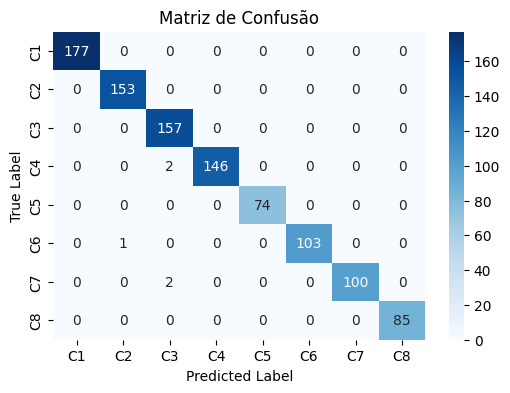

In [23]:
# Plotar a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_momentum, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de Confusão')
plt.show()

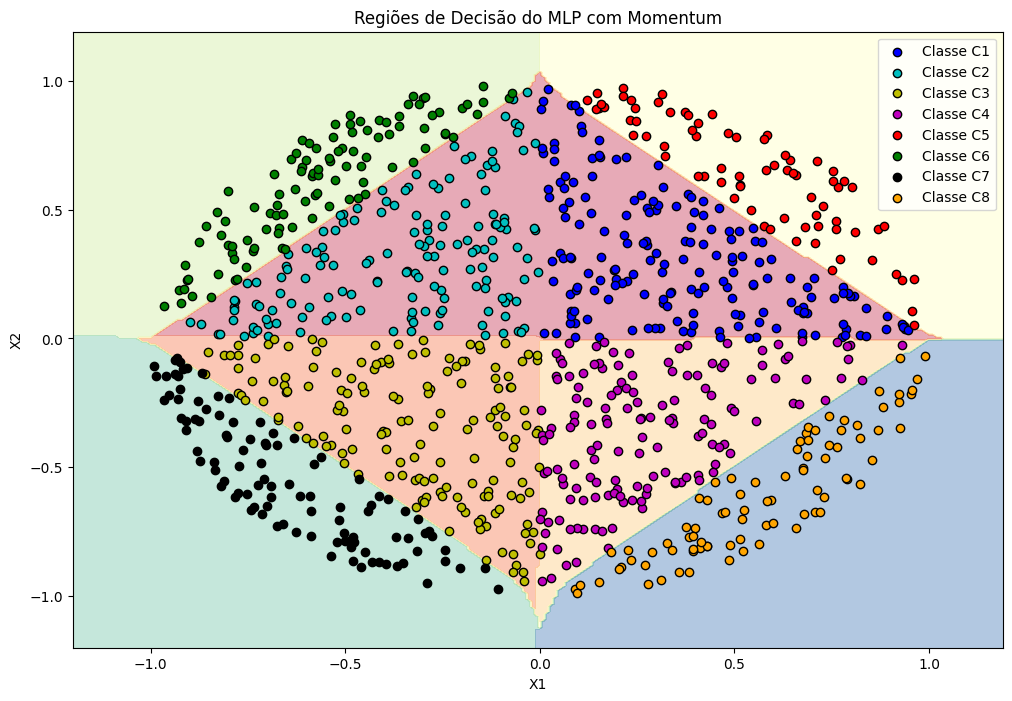

In [24]:
# Definir os limites da grade e criar uma grade de pontos
x_min, x_max = -1.2, 1.2
y_min, y_max = -1.2, 1.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Prever classes para cada ponto na grade
grid_points = np.c_[xx.ravel(), yy.ravel()]
AL_grid, _ = L_model_forward(grid_points.T, parameters_momentum, hidden_activation='relu', output_activation='softmax_output')  # .T adicionado aqui
predictions_grid = np.argmax(AL_grid, axis=0)

# Correção para plotar as regiões de decisão
Z = predictions_grid.reshape(xx.shape)
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.4, cmap='Spectral')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# Plotar os pontos de validação
for i, color in enumerate(['blue', 'c', 'y', 'm', 'r', 'g', 'k', 'orange']):
    idx = np.where(Y_val[i, :] == 1)
    plt.scatter(X_val[0, idx], X_val[1, idx], c=color, edgecolor='k', label=f'Classe {class_dict[i]}')

plt.title('Regiões de Decisão do MLP com Momentum')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(loc='upper right')
plt.show()

# Questão 4

No contexto de redes neurais e previsão de séries temporais, a entrada \( X \) e a saída \( Y \) são geralmente definidas da seguinte maneira:

- \( X \) (Entradas): São as amostras de dados que você usará para fazer a previsão. No seu exemplo, você está usando uma janela deslizante de \( K \) valores anteriores para prever os próximos valores. Então, se \( K = 10 \), cada entrada \( X \) seria um vetor contendo 10 medidas de tempo consecutivas da série temporal, por exemplo, \( [x(n-9), x(n-8), ..., x(n)] \).

- \( Y \) (Saídas): São os valores que você quer prever. No exemplo dado, para cada vetor de entrada \( X \), a saída \( Y \) seria os próximos valores da série temporal. Se a tarefa é prever um passo à frente, \( Y \) seria \( x(n+1) \); se a tarefa é prever três passos à frente, \( Y \) seria um vetor contendo \( [x(n+1), x(n+2), x(n+3)] \).

Assim, para o exemplo de treinamento 1:
- \( X \) seria \( [x(0), x(1), ..., x(9)] \)
- \( Y \) seria \( [x(10), x(11), x(12)] \)

In [37]:
# Definindo a função da série temporal
def time_series(n):
    return np.sin(n) + np.cos(n + np.cos(n))

# Função de treinamento
def train(X_train, Y_train, X_val, Y_val, parameters, learning_rate=0.1, n_iterations=10000):
    costs = []  # para manter o registro do custo
    cost_Val = []
    for i in range(n_iterations):
        # Passo para frente
        AL, caches = L_model_forward(X_train, parameters, hidden_activation='relu', output_activation='linear')
        
        # Calcular o custo
        cost = compute_cost(AL, Y_train, problema='regressao')
        costs.append(cost)
        
        # Retropropagação
        grads = L_model_backward(AL, Y_train, caches, hidden_activation='relu', output_activation='linear', problema='regressao')
        
        # Atualizar parâmetros
        parameters = update_parameters(parameters, grads, learning_rate)

        # Propagação pra frente validação
        AL_val, _ = L_model_forward(X_val, parameters, hidden_activation='relu', output_activation='linear')

        # Calculo do custo validação
        cost_val = compute_cost(AL_val, Y_val, problema='regressao')
        cost_Val.append(cost_val)
        
        # Imprimir o custo a cada 100 iterações
        if i % 100 == 0:
            print(f"Iteração {i} - Custo de Treinamento: {cost} - Custo de Validação: {cost_val}")
    
    return parameters, costs

# Função para inicializar e treinar o modelo, fazer previsões e plotar
def run_model(N, K, p, learning_rate=0.1, n_iterations=10000):
    time_steps = np.arange(N)
    data = time_series(time_steps)

    # Preparando os dados de entrada (X) e saída (Y)
    X = np.array([data[i:i+K] for i in range(N-K-p)])
    Y = np.array([data[i+K:i+K+p] for i in range(N-K-p)])

    # Dados de treinamento 70%
    X_train = X[:int(0.7 * len(X))].T
    Y_train = Y[:int(0.7 * len(Y))].T

    # Dados de validação 15%
    X_val = X[int(0.7 * len(X)):int(0.85 * len(X))].T
    Y_val = Y[int(0.7 * len(Y)):int(0.85 * len(Y))].T

    # Dados de teste 15%
    X_test = X[int(0.85 * len(X)):].T
    Y_test = Y[int(0.85 * len(Y)):].T

    # Definição das dimensões das camadas
    layer_dims = [X_train.shape[0], 100, Y_train.shape[0]]

    # Inicialização dos parâmetros
    parameters = initialize_parameters_deep(layer_dims)

    # Treinamento do modelo
    trained_parameters, costs = train(X_train, Y_train, X_val, Y_val, parameters, learning_rate, n_iterations)

    # Previsões com o modelo treinado
    predictions, _ = L_model_forward(X_test, trained_parameters, hidden_activation='relu', output_activation='linear')

    # Plotagem dos resultados
    plt.figure(figsize=(14, 6))
    inicio_teste = N - len(X_test.T) - p
    fim_teste = N - p

    # Dados de Treino
    plt.plot(time_steps[:inicio_teste], data[:inicio_teste], label='Dados de Treino', color='blue')
    # Dados de Teste
    plt.plot(time_steps[inicio_teste:fim_teste], data[inicio_teste:fim_teste], label='Dados de Teste', color='green')

    # Previsões
    for i in range(len(X_test.T)):
        start_index = inicio_teste + i
        end_index = start_index + p
        if end_index <= fim_teste:
            # Modificação aqui: usar plt.scatter para plotar pontos em vez de linhas
            if p == 1:
                plt.scatter(time_steps[start_index], predictions[:, i], color='red', label='Previsão' if i == 0 else "", zorder=5)
            else:
                # Para p > 1, plotamos pontos para cada previsão
                plt.scatter(time_steps[start_index:end_index], predictions[:, i], color='red', label='Previsão' if i == 0 else "", zorder=5)

    plt.title('Comparação das Previsões da Rede Neural com a Série Temporal')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()

    mae = np.mean(np.abs(predictions - Y_test))
    print(f"Erro Absoluto Médio (MAE) para previsão de {p} passos: {mae}")

    return predictions


### Previsão de 1 passo:

Iteração 0 - Custo de Treinamento: 0.887885990446273 - Custo de Validação: 0.8812242632293891
Iteração 100 - Custo de Treinamento: 0.8440988360944953 - Custo de Validação: 0.8495763117577682
Iteração 200 - Custo de Treinamento: 0.7270346108480799 - Custo de Validação: 0.7399143002808495
Iteração 300 - Custo de Treinamento: 0.4487295274305455 - Custo de Validação: 0.4648447212552667
Iteração 400 - Custo de Treinamento: 0.17340400886213067 - Custo de Validação: 0.17529813180981346
Iteração 500 - Custo de Treinamento: 0.05936903267651081 - Custo de Validação: 0.04909266350598843
Iteração 600 - Custo de Treinamento: 0.02781184221475901 - Custo de Validação: 0.01835532045235181
Iteração 700 - Custo de Treinamento: 0.01786648393110067 - Custo de Validação: 0.01283659915663466
Iteração 800 - Custo de Treinamento: 0.013096150863362448 - Custo de Validação: 0.01106140579777485
Iteração 900 - Custo de Treinamento: 0.010226355484733284 - Custo de Validação: 0.009838078445064673


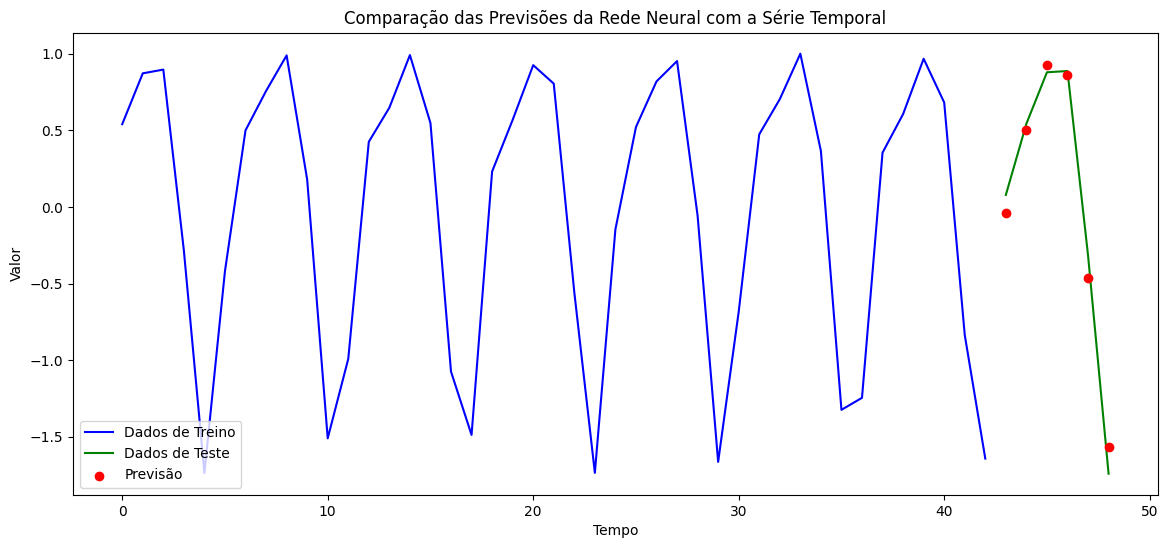

Erro Absoluto Médio (MAE) para previsão de 1 passos: 0.09277672372497807


In [38]:
predictions = run_model(N=50, K=10, p=1, learning_rate=0.1, n_iterations=1000)

### Previsão de 2 passos:

Iteração 0 - Custo de Treinamento: 1.6972018755930691 - Custo de Validação: 1.5710526580895579
Iteração 100 - Custo de Treinamento: 1.62321164217574 - Custo de Validação: 1.51230715056152
Iteração 200 - Custo de Treinamento: 1.3605017965841544 - Custo de Validação: 1.2832102392986178
Iteração 300 - Custo de Treinamento: 0.7596899250782124 - Custo de Validação: 0.7477562505391161
Iteração 400 - Custo de Treinamento: 0.3252451229435458 - Custo de Validação: 0.32734889630998243
Iteração 500 - Custo de Treinamento: 0.14585412084026966 - Custo de Validação: 0.13949067888129354
Iteração 600 - Custo de Treinamento: 0.0644853182593686 - Custo de Validação: 0.057894624333379364
Iteração 700 - Custo de Treinamento: 0.03241557723963083 - Custo de Validação: 0.02774522621993592
Iteração 800 - Custo de Treinamento: 0.019777905437202998 - Custo de Validação: 0.01663173884126081
Iteração 900 - Custo de Treinamento: 0.01366104427675065 - Custo de Validação: 0.011786334296808684


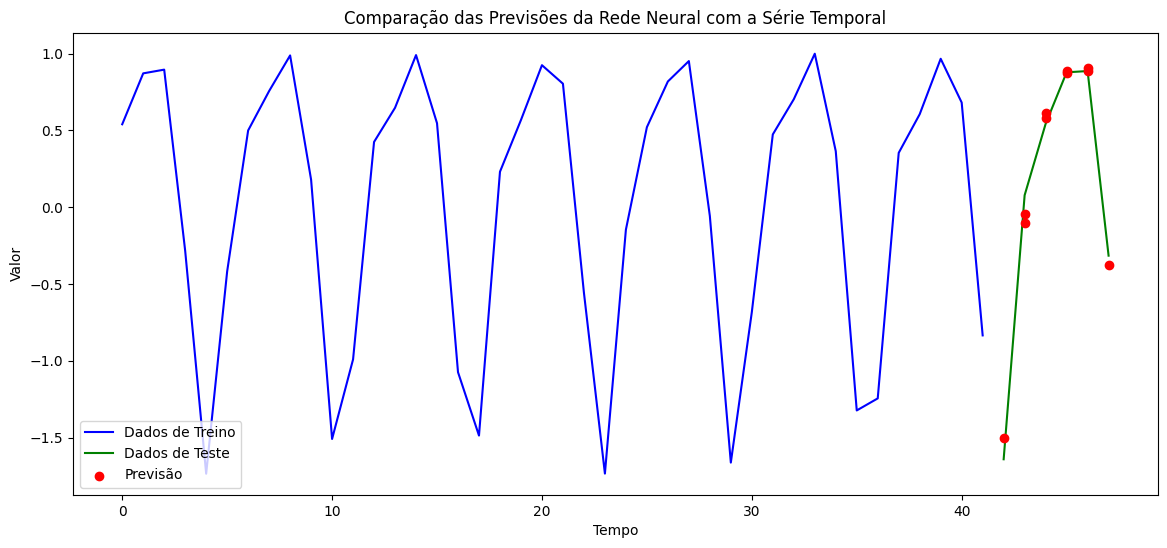

Erro Absoluto Médio (MAE) para previsão de 2 passos: 0.07591108870038449


In [39]:
predictions = run_model(N=50, K=10, p=2, learning_rate=0.1, n_iterations=1000)

### Previsão de 3 passos:

Iteração 0 - Custo de Treinamento: 2.4635132123969976 - Custo de Validação: 2.439286307135995
Iteração 100 - Custo de Treinamento: 2.3484943299550225 - Custo de Validação: 2.323251395569974
Iteração 200 - Custo de Treinamento: 1.8900692507996948 - Custo de Validação: 1.861231593716415
Iteração 300 - Custo de Treinamento: 0.8119503469402082 - Custo de Validação: 0.7825883112054314
Iteração 400 - Custo de Treinamento: 0.19268367474312606 - Custo de Validação: 0.17036115583723724
Iteração 500 - Custo de Treinamento: 0.08737302522910874 - Custo de Validação: 0.06944790107284794
Iteração 600 - Custo de Treinamento: 0.059188589505661124 - Custo de Validação: 0.04514233511000147
Iteração 700 - Custo de Treinamento: 0.04337659436920086 - Custo de Validação: 0.032962106847301297
Iteração 800 - Custo de Treinamento: 0.03329873101669613 - Custo de Validação: 0.026014524896412476
Iteração 900 - Custo de Treinamento: 0.02673144783462463 - Custo de Validação: 0.02198102024879514


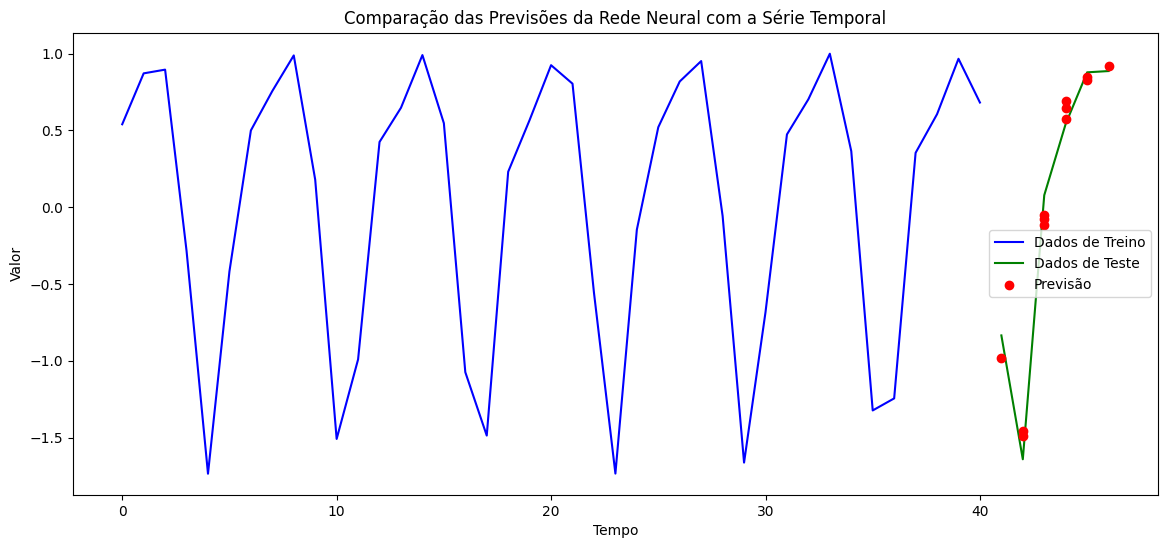

Erro Absoluto Médio (MAE) para previsão de 3 passos: 0.09859833418685332


In [40]:
predictions = run_model(N=50, K=10, p=3, learning_rate=0.1, n_iterations=1000)